In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import default_collate

torch.backends.quantized.engine = 'qnnpack'

def activation(x):
    beta = 5
    return 2 * torch.sigmoid(beta * x) * (1 + beta * torch.sigmoid(beta * x)) - 1

class BNN(nn.Module):
    def __init__(self, hidden_size=128):
        super(BNN, self).__init__()
        kernel_size_1 = 16
        kernel_size_2 = 29 - kernel_size_1
        intermediate_size = hidden_size
        self.fc1 = nn.Linear(768, intermediate_size, bias=False)
        self.clip1 = nn.Hardtanh(-1, 1)
        self.fc2 = nn.Linear(intermediate_size, 10, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.clip1(x)
        x = self.fc2(x)
        x = x.view(-1, 10)
        return x

def train(model, trainloader, weight_decay=0.0000):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            inputs = inputs.view(-1, 1, 28 * 28)
            inputs = inputs[:, :, :768]
            labels = labels.to(device)
            outputs = model(inputs)
            labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
        accuracy = test_normal(model, testloader)
        accuracy_list.append(accuracy)
        print()
    return accuracy_list

def test_normal(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 1, 28 * 28)
            inputs = inputs[:, :, :768]
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network unrounded on the 10000 test images: {accuracy} %')
    return accuracy

if __name__ == '__main__':
    training = True
    device = "cpu"
    batch_size = 2000
    test_batch_size = 20
    num_epochs = 50
    learning_rate = 0.0005
    weight_decay = 0.0000
    hidden_size = 96

    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: np.where(x > 0, 1, -1).astype(np.float32)), transforms.Lambda(lambda x: x[:768])])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

    if training:
        model = BNN(hidden_size=hidden_size)
        accuracy_list = train(model, trainloader, weight_decay=weight_decay)
        torch.save(model.state_dict(), 'bnn_model.pth')
    else:
        model = BNN(hidden_size=hidden_size)
        model.load_state_dict(torch.load('bnn_model.pth'))
        model.eval()
        test_normal(model, testloader)

Epoch 1, Loss: 1.3666725297768911
Accuracy of the network unrounded on the 10000 test images: 84.34 %

Epoch 2, Loss: 0.6411209424336751
Accuracy of the network unrounded on the 10000 test images: 88.19 %

Epoch 3, Loss: 0.46634751856327056
Accuracy of the network unrounded on the 10000 test images: 89.97 %

Epoch 4, Loss: 0.3909155170122782
Accuracy of the network unrounded on the 10000 test images: 90.73 %

Epoch 5, Loss: 0.3476671576499939
Accuracy of the network unrounded on the 10000 test images: 91.25 %

Epoch 6, Loss: 0.3182675590117772
Accuracy of the network unrounded on the 10000 test images: 91.71 %

Epoch 7, Loss: 0.2962315817674001
Accuracy of the network unrounded on the 10000 test images: 92.03 %

Epoch 8, Loss: 0.27894111375013986
Accuracy of the network unrounded on the 10000 test images: 92.53 %

Epoch 9, Loss: 0.264066344499588
Accuracy of the network unrounded on the 10000 test images: 92.6 %

Epoch 10, Loss: 0.2509932612379392
Accuracy of the network unrounded on t

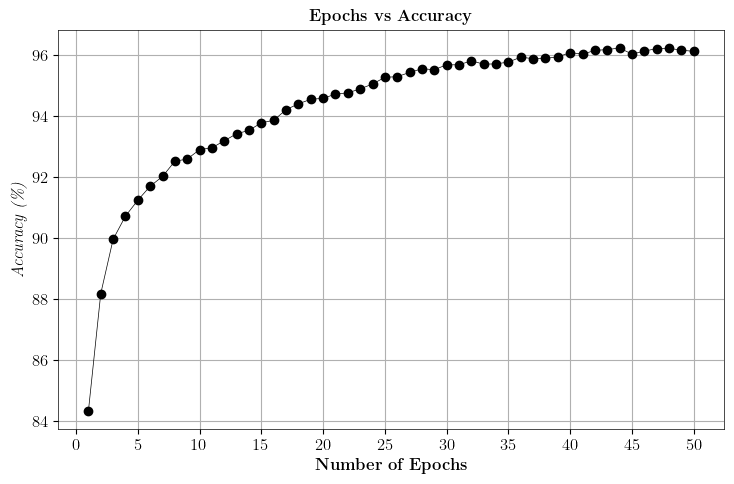

In [10]:
import matplotlib.pyplot as plt

# Assuming `accuracy_list` is loaded from the previous block
epochs = list(range(1, len(accuracy_list) + 1))

# Use LaTeX for text rendering
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

fig, ax = plt.subplots(figsize=(7.5, 5), tight_layout=True)
ax.plot(epochs, accuracy_list, marker='o', linestyle='-', color='black')

ax.set_xlabel(r'\textbf{Number of Epochs}', fontsize=12)
ax.set_ylabel(r'\textit{Accuracy (\%)}', fontsize=12)
ax.set_title(r'\textbf{Epochs vs Accuracy}', fontsize=12)
ax.set_xticks(range(0, 51, 5))
ax.grid(True)

# Save the plot as an EPS file
plt.savefig('FIG1.eps', format='eps')

plt.show()

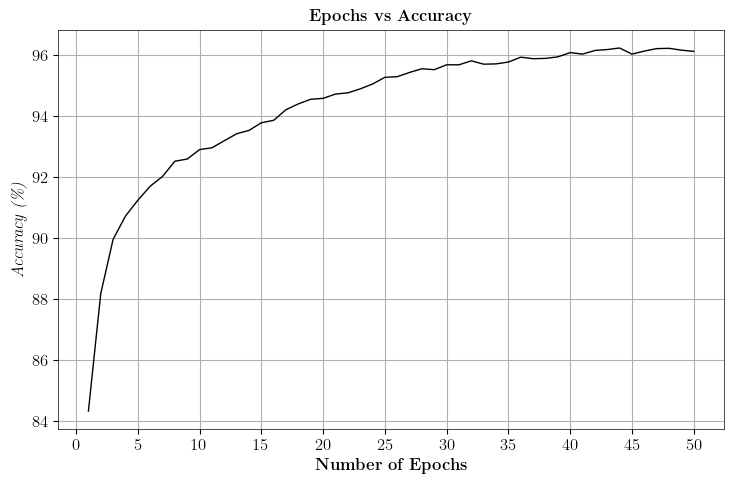

In [11]:
import matplotlib.pyplot as plt

# Assuming `accuracy_list` is loaded from the previous block
epochs = list(range(1, len(accuracy_list) + 1))

# Use LaTeX for text rendering
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 1.0,  # Increased line width for better visibility
    'axes.linewidth': 0.5,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

fig, ax = plt.subplots(figsize=(7.5, 5), tight_layout=True)
ax.plot(epochs, accuracy_list, linestyle='-', color='black')  # Removed marker='o'

ax.set_xlabel(r'\textbf{Number of Epochs}', fontsize=12)
ax.set_ylabel(r'\textit{Accuracy (\%)}', fontsize=12)
ax.set_title(r'\textbf{Epochs vs Accuracy}', fontsize=12)
ax.set_xticks(range(0, 51, 5))
ax.grid(True)

# Save the plot as an EPS file
plt.savefig('FIG1.eps', format='eps')

plt.show()